# Price stock tendency prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
from tqdm.notebook import trange, tqdm

from DataHelper import *

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
DATA_PATH = './data'
QUOTATION = 'GOOG'
FILE_SUFFIX = '.txt'

In [3]:
df = get_data(DATA_PATH, f"{QUOTATION}{FILE_SUFFIX}")
df.head()

,Date,Open,High,Low,Close,Volume,Adjusted
1,2007-01-03,232.129913,237.440018,229.694046,232.921951,15470700.0,232.921951
2,2007-01-04,233.624313,241.071411,233.300537,240.727692,15834200.0,240.727692
3,2007-01-05,240.349106,242.839783,238.162308,242.685349,13795600.0,242.685349
4,2007-01-08,242.934418,244.020355,240.199677,240.887100,9544400.0,240.887100
5,2007-01-09,241.818604,243.213379,239.701538,241.843506,10803000.0,241.843506


In [4]:
price_column = 'Close'
keep_columns = ['Date', price_column, 'Volume']

In [5]:
df = df.loc[:, keep_columns]

print(len(df))
df.head()

3525


,Date,Close,Volume
1,2007-01-03,232.921951,15470700.0
2,2007-01-04,240.727692,15834200.0
3,2007-01-05,242.685349,13795600.0
4,2007-01-08,240.887100,9544400.0
5,2007-01-09,241.843506,10803000.0


In [6]:
df.isna().any()

Date      False
Close     False
Volume    False
dtype: bool

### Plots

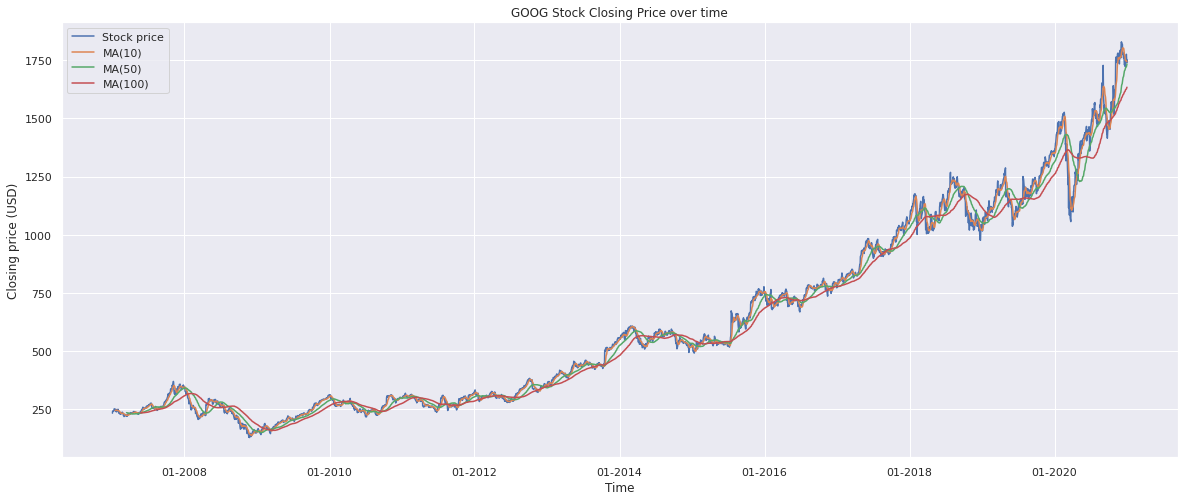

In [7]:
import datetime
import matplotlib.dates as mdates

N_YEARS = 50
values = df.tail(365*N_YEARS)[price_column]

x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in df.tail(365*N_YEARS).Date]
ax = plt.gca()
ax.set(title=f"{QUOTATION} Stock Closing Price over time", ylabel='Closing price (USD)', xlabel='Time')

formatter = mdates.DateFormatter("%m-%Y")

ax.xaxis.set_major_formatter(formatter)

MAs = [10, 50, 100]

plt.plot(x_values, values, label="Stock price")

for val in MAs:
    plt.plot(x_values, values.rolling(val).mean(), label=f"MA({val})")

plt.legend(loc='best')

### Preprocessing, compute some indicators

In [8]:
df['Difference'] = compute_price_difference(df, price_column=price_column)
df['PercentageDiff'] = compute_percentage_diff(df)

### Plot histogram differences

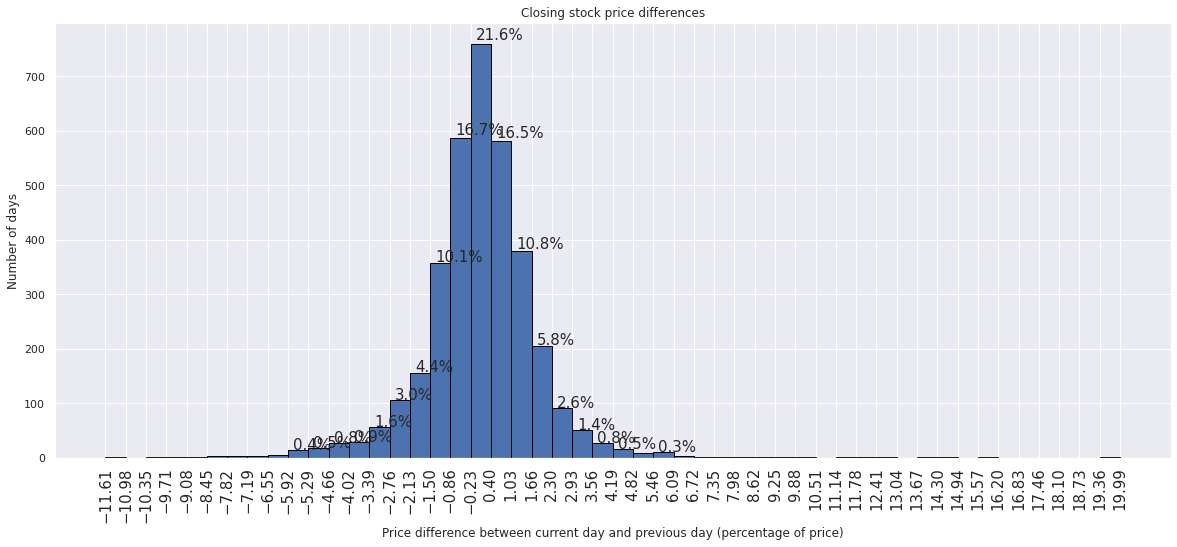

In [9]:
import matplotlib.ticker as mtick

def label_density_hist(ax, n, bins, x=4, y=0.01, r=0, **kwargs):
    """
    adapted from https://stackoverflow.com/questions/6352740/matplotlib-label-each-bin
    """
    
    total = sum(n)

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = (bins[i + 1] - bins[i]) / x + bins[i]
        y_pos = n[i] + (n[i] * y)
        
        if n[i] < 10:
            continue
        
        label = f"{(n[i] * 100.0 / total):.1f}%"
        ax.text(x_pos, y_pos, label, kwargs)
        
values = df['PercentageDiff']
ax = plt.gca()

counts, bins, patches = ax.hist(values, 50, histtype='bar', ec='black')
plt.xticks(bins, fontsize=15, rotation=90)
plt.title("Closing stock price differences")
plt.xlabel('Price difference between current day and previous day (percentage of price)')
plt.ylabel('Number of days')
label_density_hist(ax, counts, bins, fontsize=15)
plt.show()

### Compute the price tendency (IE going up or down since yesterday)

In [10]:
# in percentage
THRESH_DIFF = 0.5

# use some sort of log ?

df['Tendency'] = compute_tendency_percentage(df, diff_column='Difference', labels=['lower','stay', 'higher'], thresh_diff=THRESH_DIFF)
value_counts = df.Tendency.value_counts().to_dict()

for value, count in value_counts.items():
    print(f"[{value}] : {count} ({count * 100.0 / len(df['Tendency']):.1f}%)")
    
df.head(50)

[higher] : 1276 (36.2%)
[stay] : 1184 (33.6%)
[lower] : 1065 (30.2%)


,Date,Close,Volume,Difference,PercentageDiff,Tendency
1,2007-01-03,232.921951,15470700.0,0.000000,0.000000,stay
2,2007-01-04,240.727692,15834200.0,7.805741,3.351226,higher
3,2007-01-05,242.685349,13795600.0,1.957657,0.813225,higher
4,2007-01-08,240.887100,9544400.0,-1.798249,-0.740980,lower
5,2007-01-09,241.843506,10803000.0,0.956406,0.397035,stay
6,2007-01-10,243.816116,11981700.0,1.972610,0.815656,higher
7,2007-01-11,248.926956,14470400.0,5.110840,2.096186,higher
8,2007-01-12,251.557098,8980800.0,2.630142,1.056592,higher
9,2007-01-16,251.198441,15194500.0,-0.358657,-0.142575,stay
10,2007-01-17,247.711517,13448300.0,-3.486924,-1.388115,lower


### Add the rolling average

In [11]:
N=10

df[f"MA({N})"] = df[price_column].rolling(N).mean()

print(df.head(15))

          Date       Close      Volume  Difference  PercentageDiff Tendency  \
1   2007-01-03  232.921951  15470700.0    0.000000        0.000000     stay   
2   2007-01-04  240.727692  15834200.0    7.805741        3.351226   higher   
3   2007-01-05  242.685349  13795600.0    1.957657        0.813225   higher   
4   2007-01-08  240.887100   9544400.0   -1.798249       -0.740980    lower   
5   2007-01-09  241.843506  10803000.0    0.956406        0.397035     stay   
6   2007-01-10  243.816116  11981700.0    1.972610        0.815656   higher   
7   2007-01-11  248.926956  14470400.0    5.110840        2.096186   higher   
8   2007-01-12  251.557098   8980800.0    2.630142        1.056592   higher   
9   2007-01-16  251.198441  15194500.0   -0.358657       -0.142575     stay   
10  2007-01-17  247.711517  13448300.0   -3.486924       -1.388115    lower   
11  2007-01-18  243.004166  11908400.0   -4.707351       -1.900336    lower   
12  2007-01-19  243.960571   9993800.0    0.956405  

### Add rolling average difference 

In [12]:
N_a = 20
N_b = 10

df[f"MA_diff"] = df[price_column].rolling(N_a).mean() - df[price_column].rolling(N_b).mean()

### Add the RSI

In [13]:
N = 14

df[f"RSI({N})"] = compute_RSI(df, 10, price_column=price_column, diff_column='Difference')

### Shift the tendencies to predict next day

In [14]:
def shift_values(df, column):
    shifted_column = df[column]
    shifted_column = shifted_column.shift(periods=-1)    
    df['Next'] = shifted_column
     
shift_values(df, 'Tendency')

print(df)

            Date        Close      Volume  Difference  PercentageDiff  \
1     2007-01-03   232.921951  15470700.0    0.000000        0.000000   
2     2007-01-04   240.727692  15834200.0    7.805741        3.351226   
3     2007-01-05   242.685349  13795600.0    1.957657        0.813225   
4     2007-01-08   240.887100   9544400.0   -1.798249       -0.740980   
5     2007-01-09   241.843506  10803000.0    0.956406        0.397035   
...          ...          ...         ...         ...             ...   
3521  2020-12-24  1738.849976    346800.0    6.469971        0.373473   
3522  2020-12-28  1776.089966   1393000.0   37.239990        2.141645   
3523  2020-12-29  1758.719971   1299400.0  -17.369995       -0.977991   
3524  2020-12-30  1739.520020   1306100.0  -19.199951       -1.091700   
3525  2020-12-31  1751.880005   1011900.0   12.359985        0.710540   

     Tendency       MA(10)    MA_diff    RSI(14)    Next  
1        stay          NaN        NaN        NaN  higher  
2    

### Remove nulls introduced by previous operations

In [15]:
df = df.dropna()

### ML Data preparation

In [16]:
data_columns = ['Close', 'PercentageDiff', f"RSI({N})", 'Next', 'Volume']

dataset = df.copy()

dataset = df.loc[:, data_columns]
#df = df.drop(columns=['Tendency', 'Date', 'Difference'])

dataset.head()

,Close,PercentageDiff,RSI(14),Next,Volume
20,249.813644,1.452502,52.881736,lower,24503600.0
21,239.975510,-3.938189,46.360144,stay,31434700.0
22,239.850983,-0.051892,44.960305,lower,12620000.0
23,232.707748,-2.978197,42.163145,higher,14467800.0
24,234.859695,0.924742,45.785558,stay,10683600.0


### Dataset class balance

<AxesSubplot:>

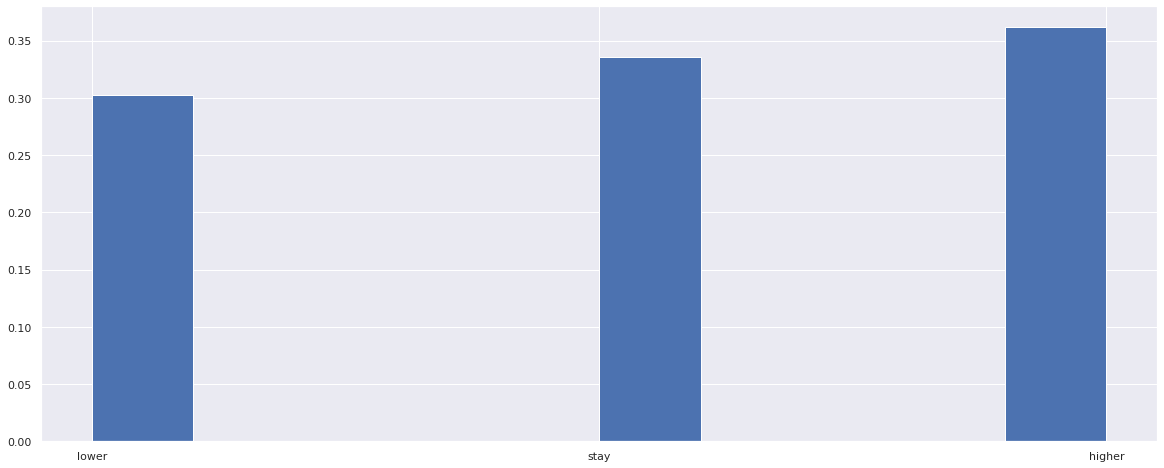

In [17]:
# plot normalized histogram
dataset['Next'].hist(weights = np.ones_like(dataset.Next) / len(dataset.Next))

### Train / Test data 

In [18]:
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']

In [19]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(X_train)}, test size : {len(X_test)} ({(1-TRAIN_RATIO)*100:.0f}%)")

# use bins

Train size : 2453, test size : 1052 (30%)


## Classifier and evaluation

In [20]:
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = False

if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', np.unique(Y), Y)
    # format as dict
    class_weights = {c:w for c,w in zip(np.unique(Y), class_weights)}

    print(class_weights)
else:
    class_weights = None

### Grid Search

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = False

# default parameters
best_params = {'DTree': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 15}, 
               'RandomForest': {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 100}, 
               'SVM': {'gamma': 'auto'}, 
               'LR': {'penalty': 'l2', 'C': 1.0}
              }

param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        'C':[1.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], n_jobs=4)

    
    clf.fit(X_train, Y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], n_jobs=8)
    clf.fit(X_train, Y_train)
    best_params['RandomForest'] = clf.best_params_

    
    """svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], n_jobs=4, verbose=30)
    clf.fit(X_train, Y_train)
    best_params['SVM'] = clf.best_params_"""
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], n_jobs=4)
    clf.fit(X_train, Y_train)


    print(best_params)

### Classifiers

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [23]:
print("Training...")

for clf_label, clf in clf_dict.items():
    clf.fit(X_train, Y_train)
    
print("Training done.")

Training...
Training done.


[DTree] Accuracy : 0.40, F1 : 0.41
[RandomForest] Accuracy : 0.41, F1 : 0.45
[SVM] Accuracy : 0.38, F1 : 0.55
[LR] Accuracy : 0.38, F1 : 0.55


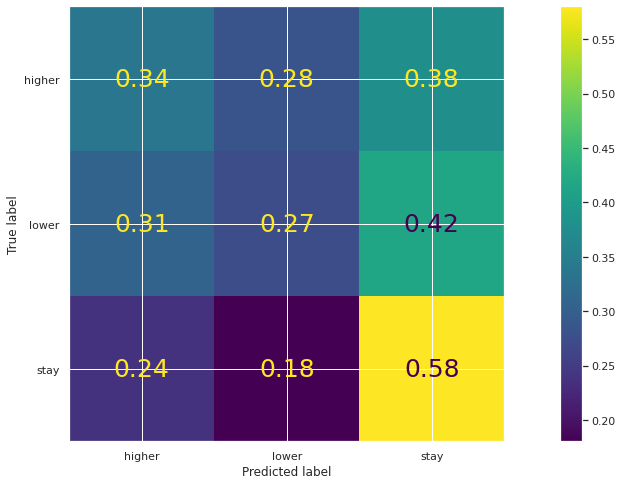

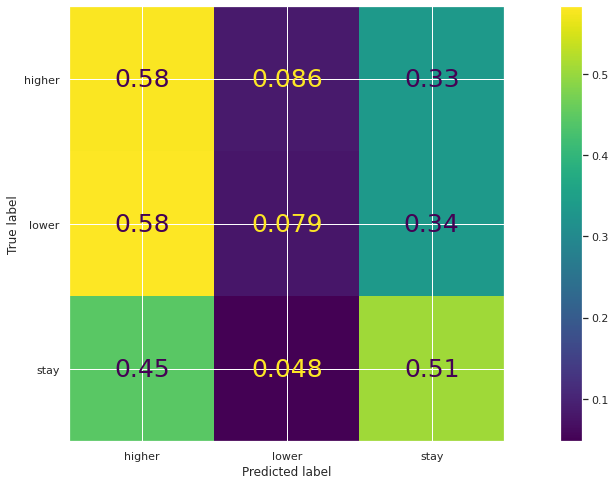

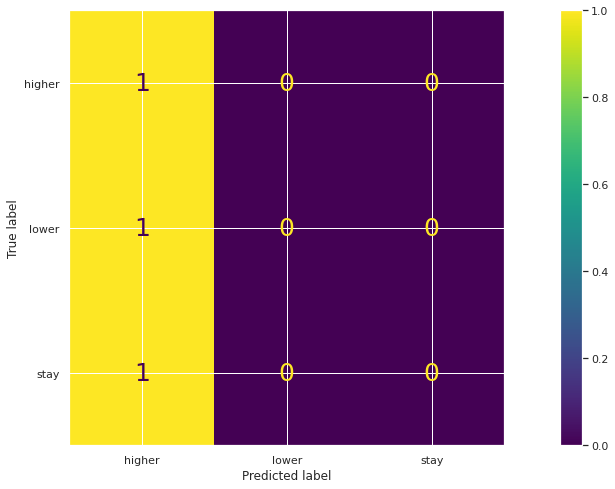

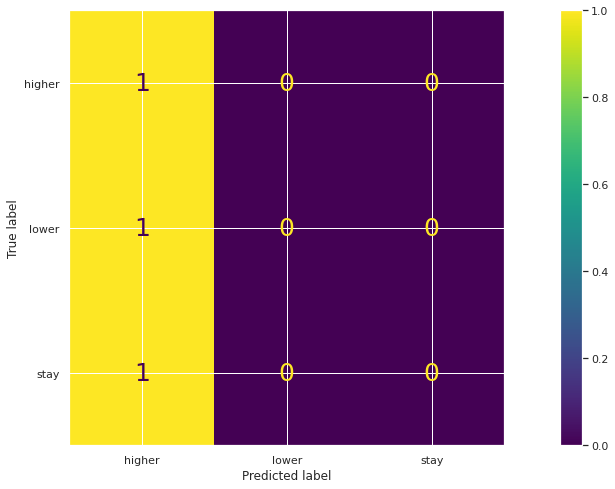

In [38]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

for clf_label, clf in clf_dict.items():
    with mlflow.start_run(run_name=clf_label):
        Y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(Y_pred, Y_test)
        f1 = f1_score(Y_pred, Y_test, average='weighted')
        


        for param, val in best_params[clf_label].items():
            mlflow.log_param(param, val)
        mlflow.log_metric('acc', accuracy)
        mlflow.log_metric('f1', f1)
        mlflow.sklearn.log_model(clf, "sklearn model")
    
    print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
    plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

In [ ]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

#print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(list(X_train.columns)))

print(rules)